<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Dual_Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR", "Dual Memory ICMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
# Parameters
data_path = "data/LohnasKahana2014.csv"
trial_query = "condition == 4"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_1_0_0", "ICMR_1_0_1", "ICMR_1_1_0", "ICMR_1_1_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]
section_tag = "LohnasKahanaCond4"


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function lohnas_objective_function.<locals>.objective_function at 0x2b26df90a4c0>


1142.7285129177264
3080.8590394275197


<function lohnas_objective_function.<locals>.objective_function at 0x2b26e10618b0>


1142.7285129177264
3080.8590394275197
<function lohnas_objective_function.<locals>.objective_function at 0x2b26e1635430>


1142.7285129177264
3080.8590394275197
<function lohnas_objective_function.<locals>.objective_function at 0x2b26e19515e0>


1143.555731544549
3080.8590394275197
<function lohnas_objective_function.<locals>.objective_function at 0x2b26e090e670>


1143.555731544549
3080.8590394275197
dependencies and parameters validated


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag LohnasKahanaCond4 already exist
ICMR_1_0_0, Subject 1


571.465430949909
ICMR_1_0_0, Subject 2


400.39882890492845
ICMR_1_0_0, Subject 3


601.3442581486535
ICMR_1_0_0, Subject 4


262.0220241219612
ICMR_1_0_0, Subject 5


605.140234686384
ICMR_1_0_0, Subject 6


627.6702580677486
ICMR_1_0_0, Subject 7


302.61005877805604
ICMR_1_0_0, Subject 8


650.9806172084086
ICMR_1_0_0, Subject 10


452.86131307955276
ICMR_1_0_0, Subject 11


660.8299555532764
ICMR_1_0_0, Subject 12


615.6827211834585
ICMR_1_0_0, Subject 13


574.4212355171315
ICMR_1_0_0, Subject 14


877.170669313767
ICMR_1_0_0, Subject 15


442.4950128294928
ICMR_1_0_0, Subject 16


576.8164832716815
ICMR_1_0_0, Subject 17


468.734350681548
ICMR_1_0_0, Subject 18


500.1453396102445
ICMR_1_0_0, Subject 19


463.88766966381087
ICMR_1_0_0, Subject 20


308.29063490129977
ICMR_1_0_0, Subject 21


608.9452556965097
ICMR_1_0_0, Subject 22


224.84916424623233
ICMR_1_0_0, Subject 23


361.0433519266264
ICMR_1_0_0, Subject 24


436.93691335863855
ICMR_1_0_0, Subject 25


493.6519926303308
ICMR_1_0_0, Subject 27


249.08622957789277
ICMR_1_0_0, Subject 28


294.5484592625063
ICMR_1_0_0, Subject 29


459.5932553466888
ICMR_1_0_0, Subject 30


334.6659629995147
ICMR_1_0_0, Subject 31


362.64579616232265
ICMR_1_0_0, Subject 32


607.2093081507072
ICMR_1_0_0, Subject 33


445.5976305049772
ICMR_1_0_0, Subject 34


527.058979196905
ICMR_1_0_0, Subject 35


510.4896577661391
ICMR_1_0_0, Subject 36


481.6486267593974
ICMR_1_0_0, Subject 37


192.9488347881198


ICMR_1_0_1, Subject 1


571.3902512362181
ICMR_1_0_1, Subject 2


364.15625478374346
ICMR_1_0_1, Subject 3


605.0475745685992
ICMR_1_0_1, Subject 4


263.97334236963974
ICMR_1_0_1, Subject 5


608.9594582175014
ICMR_1_0_1, Subject 6


677.3167284943049
ICMR_1_0_1, Subject 7


312.7097067493928
ICMR_1_0_1, Subject 8


636.4416784998502
ICMR_1_0_1, Subject 10


453.1514377428656
ICMR_1_0_1, Subject 11


687.677109646768
ICMR_1_0_1, Subject 12


612.3226738087158
ICMR_1_0_1, Subject 13


574.9379757786879
ICMR_1_0_1, Subject 14


867.1418406342013
ICMR_1_0_1, Subject 15


442.4293218934436
ICMR_1_0_1, Subject 16


567.7234675670059
ICMR_1_0_1, Subject 17


469.55848928799924
ICMR_1_0_1, Subject 18


494.85876131945804
ICMR_1_0_1, Subject 19


463.47796083798625
ICMR_1_0_1, Subject 20


305.08264029289484
ICMR_1_0_1, Subject 21


603.9616681799562
ICMR_1_0_1, Subject 22


228.1577376703661
ICMR_1_0_1, Subject 23


381.7158843051567
ICMR_1_0_1, Subject 24


436.95056178786587
ICMR_1_0_1, Subject 25


502.1817688102874
ICMR_1_0_1, Subject 27


249.66417933395562
ICMR_1_0_1, Subject 28


294.51992395656515
ICMR_1_0_1, Subject 29


457.43729676095245
ICMR_1_0_1, Subject 30


334.5725376475555
ICMR_1_0_1, Subject 31


362.2202844568727
ICMR_1_0_1, Subject 32


608.1226139838323
ICMR_1_0_1, Subject 33


444.7230923113528
ICMR_1_0_1, Subject 34


527.7862234282113
ICMR_1_0_1, Subject 35


509.78881630739704
ICMR_1_0_1, Subject 36


481.35904633047585
ICMR_1_0_1, Subject 37


193.00341554451634
ICMR_1_1_0, Subject 1


565.6521981924445
ICMR_1_1_0, Subject 2


412.7086590130244
ICMR_1_1_0, Subject 3


600.851240716453
ICMR_1_1_0, Subject 4


264.6421231113051
ICMR_1_1_0, Subject 5


604.9854386891011
ICMR_1_1_0, Subject 6


626.842058153924
ICMR_1_1_0, Subject 7


296.0964740794183
ICMR_1_1_0, Subject 8


644.1415643554061
ICMR_1_1_0, Subject 10


456.28941231038226
ICMR_1_1_0, Subject 11


712.47108295642
ICMR_1_1_0, Subject 12


625.8137559499634
ICMR_1_1_0, Subject 13


607.4008667498078
ICMR_1_1_0, Subject 14


849.433341672138
ICMR_1_1_0, Subject 15


442.0164441997566
ICMR_1_1_0, Subject 16


568.2223204851047
ICMR_1_1_0, Subject 17


469.2608983432954
ICMR_1_1_0, Subject 18


494.95428471981256
ICMR_1_1_0, Subject 19


461.79565875398123
ICMR_1_1_0, Subject 20


303.174837939781
ICMR_1_1_0, Subject 21


603.1787652826307
ICMR_1_1_0, Subject 22


228.9147521938339
ICMR_1_1_0, Subject 23


366.45172871142427
ICMR_1_1_0, Subject 24


437.72698031369305
ICMR_1_1_0, Subject 25


493.29545740848545
ICMR_1_1_0, Subject 27


252.25774474719734
ICMR_1_1_0, Subject 28


294.61618204694076
ICMR_1_1_0, Subject 29


456.70351798898014
ICMR_1_1_0, Subject 30


355.38187526562314
ICMR_1_1_0, Subject 31


363.90360330605057
ICMR_1_1_0, Subject 32


607.6762295338237
ICMR_1_1_0, Subject 33


445.72086434342015
ICMR_1_1_0, Subject 34


525.230983539032
ICMR_1_1_0, Subject 35


509.46035404267417
ICMR_1_1_0, Subject 36


481.9528570032923
ICMR_1_1_0, Subject 37


193.95698329605563
ICMR_1_1_1, Subject 1


566.9832590322892
ICMR_1_1_1, Subject 2


360.1560538026343
ICMR_1_1_1, Subject 3


608.6969251152218
ICMR_1_1_1, Subject 4


262.13640737563213
ICMR_1_1_1, Subject 5


604.9818788811037
ICMR_1_1_1, Subject 6


627.006036317145
ICMR_1_1_1, Subject 7


311.11836594631745
ICMR_1_1_1, Subject 8


650.4150657464501
ICMR_1_1_1, Subject 10


453.69041932833017
ICMR_1_1_1, Subject 11


659.3729871080368
ICMR_1_1_1, Subject 12


617.0988516378593
ICMR_1_1_1, Subject 13


576.3054949379847
ICMR_1_1_1, Subject 14


862.6330036638436
ICMR_1_1_1, Subject 15


442.3780229928401
ICMR_1_1_1, Subject 16


561.8859448862985
ICMR_1_1_1, Subject 17


477.1118279689417
ICMR_1_1_1, Subject 18


494.872467886859
ICMR_1_1_1, Subject 19


463.67827457796136
ICMR_1_1_1, Subject 20


304.00993526484785
ICMR_1_1_1, Subject 21


633.9989557175674
ICMR_1_1_1, Subject 22


230.62601664938848
ICMR_1_1_1, Subject 23


361.96733812417745
ICMR_1_1_1, Subject 24


438.7018478886512
ICMR_1_1_1, Subject 25


522.5621099975247
ICMR_1_1_1, Subject 27


251.96267209717212
ICMR_1_1_1, Subject 28


295.4604872113084
ICMR_1_1_1, Subject 29


461.57272914331907
ICMR_1_1_1, Subject 30


348.5319191439884
ICMR_1_1_1, Subject 31


360.94483778093246
ICMR_1_1_1, Subject 32


607.3359260626991
ICMR_1_1_1, Subject 33


447.2641742123855
ICMR_1_1_1, Subject 34


525.0763518052612
ICMR_1_1_1, Subject 35


509.46121166290993
ICMR_1_1_1, Subject 36


483.33100611568284
ICMR_1_1_1, Subject 37


194.4170046683119


Text(-1.8055555555555483, 0.5, 'Individual Log-Likelihood')

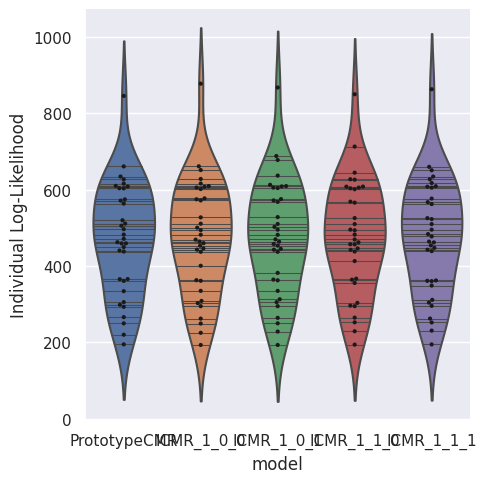

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learn_first
0,1,12,570.955428,PrototypeCMR,0.852156,6.300297e-02,0.973207,0.019302,0.259307,0.307303,6.044598,3.097731,0.000216,0.362137,1.170036,9.974672e-01,NaN,NaN,NaN
1,2,12,360.809973,PrototypeCMR,0.775959,5.741804e-04,0.948820,0.892383,0.386590,0.530834,3.640929,70.418258,0.039439,0.098614,8.910311,9.999966e-01,NaN,NaN,NaN
2,3,12,603.498286,PrototypeCMR,0.781675,9.449777e-02,0.988624,0.150700,1.000000,0.349989,8.880948,0.697555,0.004007,0.197674,1.641359,4.568914e-01,NaN,NaN,NaN
3,4,12,265.937735,PrototypeCMR,0.869711,2.220446e-16,0.993952,0.011394,0.649119,0.288967,40.612291,39.024797,0.062762,0.118039,0.845225,9.978126e-01,NaN,NaN,NaN
4,5,12,607.847412,PrototypeCMR,0.696208,9.936327e-01,0.913874,0.022257,0.675181,0.590791,2.014848,49.312230,0.002999,0.237998,0.847514,1.000000e+00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,33,12,447.264174,ICMR_1_1_1,0.584482,3.976145e-01,0.607972,0.000080,0.001765,1.000000,27.856115,0.745603,0.018606,0.160130,1.000000,1.861100e-05,1.0,3.775058,True
171,34,12,525.076352,ICMR_1_1_1,0.763293,1.042426e-02,0.957499,0.006029,0.480757,0.459113,11.232233,63.703896,0.008209,0.136043,1.000000,9.997197e-01,1.0,2.242431,True
172,35,12,509.461212,ICMR_1_1_1,0.861085,3.581599e-01,0.994052,0.004845,1.000000,0.545894,4.325406,45.405956,0.005023,0.214819,1.000000,2.755905e-09,1.0,1.148646,True
173,36,12,483.331006,ICMR_1_1_1,0.669901,8.936616e-01,1.000000,0.018597,0.972638,0.694371,5.722502,53.953581,0.019983,0.127663,1.000000,1.542281e-01,1.0,1.419676,True


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-LohnasKahanaCond4fits layout-nrow=2 layout-valign="center"}

![](results/individual_LohnasKahanaCond4.pdf)

|       |   ICMR_1_0_0 |   ICMR_1_0_1 |   ICMR_1_1_0 |   ICMR_1_1_1 |   PrototypeCMR |
|:------|-------------:|-------------:|-------------:|-------------:|---------------:|
| count |       35     |       35     |       35     |       35     |         35     |
| mean  |      472.968 |      474.129 |      474.948 |      473.65  |        470.223 |
| std   |      149.194 |      150.336 |      148.593 |      148.446 |        146.658 |
| min   |      192.949 |      193.003 |      193.957 |      194.417 |        194.559 |
| 25%   |      361.845 |      363.188 |      365.178 |      360.55  |        363.009 |
| 50%   |      468.734 |      469.558 |      469.261 |      477.112 |        470.901 |
| 75%   |      589.08  |      589.45  |      602.015 |      590.644 |        588.641 |
| max   |      877.171 |      867.142 |      849.433 |      862.633 |        845.141 |

Distributio

In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_1_0_0')
Ttest_relResult(statistic=-1.6911634107022189, pvalue=0.09995390362367525)
Ttest_relResult(statistic=-1.6911634107022189, pvalue=0.049976951811837624)
Ttest_relResult(statistic=-1.6911634107022189, pvalue=0.9500230481881624)

('PrototypeCMR', 'ICMR_1_0_1')
Ttest_relResult(statistic=-2.082050524985957, pvalue=0.0449348413744991)
Ttest_relResult(statistic=-2.082050524985957, pvalue=0.02246742068724955)
Ttest_relResult(statistic=-2.082050524985957, pvalue=0.9775325793127505)

('PrototypeCMR', 'ICMR_1_1_0')
Ttest_relResult(statistic=-1.9768830831418112, pvalue=0.05621035945669735)
Ttest_relResult(statistic=-1.9768830831418112, pvalue=0.028105179728348674)
Ttest_relResult(statistic=-1.9768830831418112, pvalue=0.9718948202716513)

('PrototypeCMR', 'ICMR_1_1_1')
Ttest_relResult(statistic=-2.282977663496103, pvalue=0.02880525483237517)
Ttest_relResult(statistic=-2.282977663496103, pvalue=0.014402627416187586)
Ttest_relResult(statistic=-2.282977663496103, pvalue=0

In [9]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_1_0_0')
0.5142857142857142 0.4857142857142857
18 17

('PrototypeCMR', 'ICMR_1_0_1')
0.6 0.4
21 14

('PrototypeCMR', 'ICMR_1_1_0')
0.5142857142857142 0.4857142857142857
18 17

('PrototypeCMR', 'ICMR_1_1_1')
0.5428571428571428 0.45714285714285713
19 16

('ICMR_1_0_0', 'ICMR_1_0_1')
0.4857142857142857 0.5142857142857142
17 18

('ICMR_1_0_0', 'ICMR_1_1_0')
0.5142857142857142 0.4857142857142857
18 17

('ICMR_1_0_0', 'ICMR_1_1_1')
0.5714285714285714 0.42857142857142855
20 15

('ICMR_1_0_1', 'ICMR_1_1_0')
0.5142857142857142 0.4857142857142857
18 17

('ICMR_1_0_1', 'ICMR_1_1_1')
0.5428571428571428 0.45714285714285713
19 16

('ICMR_1_1_0', 'ICMR_1_1_1')
0.5714285714285714 0.42857142857142855
20 15



In [10]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[1.00000000e+00 1.87302870e-42 4.21596589e-60 1.50694582e-72
 8.13924044e-53]


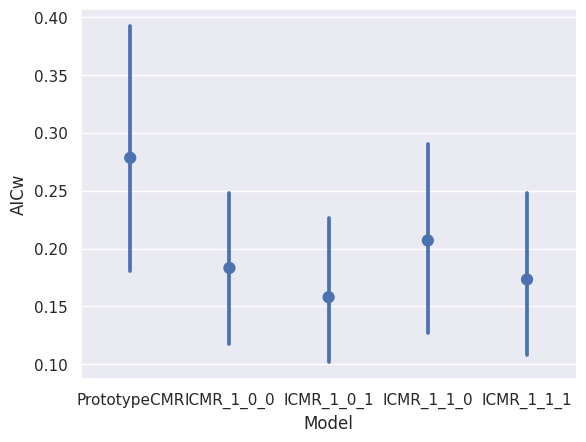

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                #model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df_from_events(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")

NameError: name 'simulate_df_from_events' is not defined